# Image Downloader

In [132]:
import os
import socket
import ssl # SSLError
import sys
import zlib

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from pyprind import ProgBar
import pandas as pd 

from pymongo import MongoClient

import requests # t SSLError
import urllib.request, urllib.error, urllib.parse
from urllib.parse import quote, unquote
from urllib.error import URLError
from urllib.parse import urlparse
from urllib.request import urlopen, url2pathname

In [133]:
# Checking we are in the correct directory
download_dir = 'imgs'
if not os.path.exists(download_dir):
    os.mkdir(download_dir)
os.listdir(download_dir)[:10]

['.DS_Store',
 'http%3A%2F%2Fgraphics8.nytimes.com%2Fimages%2F2016%2F01%2F14%2Fus%2F14TRUMPweb1%2F14TRUMPweb1-thumbStandard.jpg',
 'http%3A%2F%2Fgraphics8.nytimes.com%2Fimages%2F2016%2F01%2F20%2Fus%2F20firstdraft-Trump%2F20firstdraft-Trump-tmagArticle.jpg',
 'http%3A%2F%2Fgraphics8.nytimes.com%2Fimages%2F2016%2F01%2F21%2Fus%2F21firstdraftnl-Trump%2F21firstdraftnl-Trump-tmagArticle.jpg',
 'http%3A%2F%2Fgraphics8.nytimes.com%2Fimages%2F2016%2F01%2F22%2Fopinion%2FRFDClinton-denial%2FRFDClinton-denial-articleInline.jpg',
 'http%3A%2F%2Fgraphics8.nytimes.com%2Fimages%2F2016%2F01%2F22%2Fus%2F22firstdraft-Trump2%2F22firstdraft-Trump2-tmagArticle.jpg',
 'http%3A%2F%2Fgraphics8.nytimes.com%2Fimages%2F2016%2F01%2F27%2Fus%2F27firstdraft-newsletter%2F27firstdraft-newsletter-tmagArticle.jpg',
 'http%3A%2F%2Fgraphics8.nytimes.com%2Fimages%2F2016%2F01%2F27%2Fus%2F27firstdraft-trump%2F27firstdraft-trump-tmagArticle.jpg',
 'http%3A%2F%2Fgraphics8.nytimes.com%2Fimages%2F2016%2F01%2F27%2Fus%2F27firstdraf

## Load cvs file containing urls 

Start by loading csv file into dataframe.  
Make sure the image_urls file is in the current directory

In [134]:
#Load URL List
df = pd.read_csv('test_images_urls.csv')
image_urls = pd.Series(df['image_url']).dropna()

## Filter out urls that are not images

Filtering out all the lines that do not start by htt. 

In [135]:
urls = image_urls[ image_urls.str.startswith("htt")]
print("Valid Urls starting with \"htt*\" " + str(len(urls)) + 
      " from a total of "+ str(len(df)) + " in csv file.\n") 
df.info()

Valid Urls starting with "htt*" 256 from a total of 306 in csv file.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 7 columns):
media_source             304 non-null object
pub_date                 293 non-null object
image_url                294 non-null object
image_width              32 non-null object
image_height             31 non-null object
mediacloud_stories_id    288 non-null float64
story_url                288 non-null object
dtypes: float64(1), object(6)
memory usage: 16.8+ KB


Removing duplicated links since they must images that are logos, advertisements or other kinds of images that do not insterest us. We arbitrarely choose links that are repeated more than 10 times.

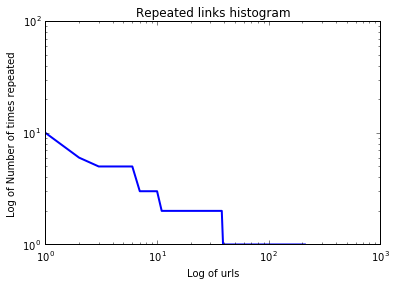

In [136]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
image_urls_counts = image_urls.value_counts()
line, = ax.plot(image_urls_counts .values, color='blue', lw=2)
ax.set_yscale('log')
ax.set_ylabel("Log of Number of times repeated")
ax.set_xscale('log')
ax.set_xlabel("Log of urls")
ax.set_title("Repeated links histogram")
plt.show()

In [137]:
print()
print("- First 10 values data ploted above: ")
print("    " + str(image_urls_counts[:10].values))
print("- Unique links:", len(image_urls.dropna().unique())) 
print("- Links found at most 10 times, should be photo: ", 
      len(image_urls_counts [image_urls_counts<=10]))
print("- Links found at least 10 times such as ads, spacers, logos:",
      len(image_urls_counts [image_urls_counts>10]))


- First 10 values data ploted above: 
    [17 10  6  5  5  5  5  3  3  3]
- Unique links: 212
- Links found at most 10 times, should be photo:  211
- Links found at least 10 times such as ads, spacers, logos: 1


In [138]:
#Remove Urls repeated more than 10 times
val_counts = urls.value_counts()
repetition_dict = {url:repeted for url,repeted in val_counts.iteritems()}
url_list = [url for url in urls if repetition_dict[url] <= 10]
urls = pd.Series(url_list)
print("Remaining urls after we remove urls repeated 10 times: ", len(urls))

Remaining urls after we remove urls repeated 10 times:  239


The cell below is optional in case we already have downloaded partialy the images under the directory "../images/img" and want to keep downloading it.

In [139]:
# Optional cell, make sure the "../images/img" path exists
# Remove files already loaded
files =  os.listdir(download_dir)
down_urls =  list(map(unquote, files))
remaining = urls[~urls.isin(down_urls)] 
#print(urls.isin(down_urls).value_counts())
#remaining = pd.read_csv('test.csv') # testing with a couple of files
print("Files downloaded: " + str(len(down_urls)))
print("Remaining files to be downloaded: " + str(len(remaining)))
remaining = pd.Series(remaining)

Files downloaded: 176
Remaining files to be downloaded: 47


In [140]:
#Removing unvalid extensions
exts =  [os.path.splitext(p)[1] for p in remaining] #croping text before "."
exts =  [ext.split('?')[0]  for ext in exts] #truncating text after extension
exts =  [ext.split('&')[0]  for ext in exts] #truncating text after extension
exts =  [ext.split('%')[0]  for ext in exts] #truncating text after extension
valid = pd.Series(exts)
img_remaining = remaining[list(valid.isin(['.jpg', '.gif' ,'.png', '.jpeg','.JPG']))] # what we keep
print("Remaining after unvalid extensions removed :" + str(len(remaining)))

Remaining after unvalid extensions removed :47


In [141]:
img_remaining

93     https://img.washingtonpost.com/wp-apps/imrs.ph...
94     https://img.washingtonpost.com/wp-apps/imrs.ph...
127    https://img.washingtonpost.com/rf/image_400w/2...
174    https://img.washingtonpost.com/wp-apps/imrs.ph...
184    http://static2.politico.com/dims4/default/431f...
185    http://static2.politico.com/dims4/default/dc91...
187    http://static2.politico.com/dims4/default/0bc6...
188    http://static2.politico.com/dims4/default/dc91...
190    http://static2.politico.com/dims4/default/3b5f...
197    http://imagestage2.politico.com/global/2015/02...
198    http://static2.politico.com/dims4/default/c460...
201    http://static2.politico.com/dims4/default/e898...
202    http://static2.politico.com/dims4/default/660a...
203    http://static2.politico.com/dims4/default/4009...
204    http://static2.politico.com/dims4/default/4fed...
207    http://static2.politico.com/dims4/default/98cd...
210    https://i.guim.co.uk/img/media/6fb6fe58c79b840...
212    https://i.guim.co.uk/img

##  Downloading images


In [142]:
# TODO: Download images with a minimum width or height
bar = ProgBar(len(remaining), monitor=True)
unfetchables = []
timeouts = []
urlerrors = []
large_names = []

for i, image_name in enumerate(remaining):
    bar.update(item_id = image_name, force_flush=True)
    img =  None
    try:
        img = urlopen(image_name, None, 0.5).read()
    except (URLError, requests.exceptions.SSLError, ssl.SSLError) as e:
        urlerrors.append((image_name,e))
        print("URLError:   ",e ,image_name)
        continue
    except socket.timeout as e:
        timeouts.append((image_name, e))
        print("Timed out!", e, image_name)
        continue
    except Exception as e:
        unfetchables.append((image_name, e))
        print("Unknow exception", e, image_name)
        continue
    filename = quote(image_name, safe="")
    if len(filename) > 250:
        large_names.append(filename)
        filename = 'L' + filename[:250]
        #print("Name too long"+filename)
    if img:
        f = open(os.path.join(download_dir,filename),'wb')
        f.write(img)
        f.close()
print("urlerros", len(urlerrors), "timeouts", len(timeouts), 
      "unfetchables", len(unfetchables), "large names", len(large_names))

0%                          100%
[####                          ] | ETA: 00:00:19 | Item ID: https://img.washingtonpost.com/rf/image_60x60/WashingtonPost/Content/Blogs/post-politics/201601/Images/2016-01-09T011541Z_01_RKH126_RTRIDSP_3_USA-ELECTIONS-

Timed out! The read operation timed out https://img.washingtonpost.com/rf/image_400w/2010-2019/Wires/Online/2016-01-05/AP/Images/GOP2016Trump-0c121.jpg?uuid=rOBCarPfEeWKvNCTku3GEg


[#####                         ] | ETA: 00:00:18 | Item ID: https://img.washingtonpost.com/rf/image_138x92/WashingtonPost/Content/Blogs/post-politics/201601/Images/2016-01-09T011541Z_01_RKH126_RTRIDSP_3_USA-ELECTIONS

URLError:    HTTP Error 403: Forbidden https://img.washingtonpost.com/rf/image_60x60/WashingtonPost/Content/Blogs/post-politics/201601/Images/2016-01-09T011541Z_01_RKH126_RTRIDSP_3_USA-ELECTIONS-


[#####                         ] | ETA: 00:00:17 | Item ID: http://feeds.washingtonpost.com/c/34656/f/636635/s/4cc12003/sc/7/l/0M0Swashingtonpost0N0Cpolitics0Ccourts0Ilaw0Cbattle0Eover0Eunions0Esignals0Esupreme0Ecourt0Erole0Eat0Ecenter0Eof0E

URLError:    HTTP Error 403: Forbidden https://img.washingtonpost.com/rf/image_138x92/WashingtonPost/Content/Blogs/post-politics/201601/Images/2016-01-09T011541Z_01_RKH126_RTRIDSP_3_USA-ELECTIONS


[#######                       ] | ETA: 00:00:15 | Item ID: http://static2.politico.com/dims4/default/431fb65/2147483647/resize/1160x%3E/quality/90/?url=http%3A%2F%2Fstatic.politico.com%2Fce%2F10%2F1f502ee04480a850d6aeef67fc37%2F20160128-donald-trump-sign-des-moines-gty-1160.jpg

URLError:    HTTP Error 404: Not Found http://feeds.washingtonpost.com/c/34656/f/636635/s/4cc12003/sc/7/l/0M0Swashingtonpost0N0Cpolitics0Ccourts0Ilaw0Cbattle0Eover0Eunions0Esignals0Esupreme0Ecourt0Erole0Eat0Ecenter0Eof0E


[###########                   ] | ETA: 00:00:09 | Item ID: http://static2.politico.com/dims4/default/e898b24/2147483647/resize/1160x%3E/quality/90/?url=http%3A%2F%2Fstatic.politico.com%2F64%2F9a%2F5f93971f4b4b910d3faa9311cd69%2F2016114-hillary-clinton-4-gty-1160.jpg

URLError:    <urlopen error [Errno 8] nodename nor servname provided, or not known> http://imagestage2.politico.com/global/2015/02/22/150222_poll_station_gty_629_90x49.jpg


[##############################] | ETA: 00:00:00 | Item ID: https://img.washingtonpost.com/wp-apps/imrs.php?src=http%3a%2f%2fs3.amazonaws.com%2fposttv-thumbnails-prod%2fthumbnails%2f55b90eb0e4b09ff16888ccab%2f20150729_RESTAURANTKIDS.jpg&w=1248&h=702
Total time elapsed: 00:00:11


urlerros 4 timeouts 1 unfetchables 0 large names 18


In [93]:
print(len(urlerrors), len(timeouts), len(unfetchables), len(large_names))

0 0 0 0


In [94]:
len(remaining)

30

# Scratch Pad

In [95]:
# Discarting malformed Urls
df = pd.read_csv('test_images_urls.csv')
urls = df['image_url'].dropna()
malformed = urls[ urls.str.contains("img.youtube.com")]
malformed_urls =  urls[ urls.str.startswith("htt")]
print(df.shape, urls.shape, urls.unique().shape, malformed_urls.unique().shape)

(70, 7) (70,) (47,) (45,)


In [96]:
#Checking images height and width
import pandas as pd
d = pd.read_csv('test_images_urls.csv')
print(d.shape)
print("** width **")
print(d['image_width'].describe())
print("** height **")
print(d['image_height'].describe())
rows_with_width = [ r for r, v in enumerate(d['image_width'].notnull()) if v]
rows_with_height = [ r for r, v in enumerate(d['image_height'].notnull()) if v]
print("rows_with_width", len(rows_with_width))
print("rows_with_height", len(rows_with_height))
print("rows_with_height and rows_with_height",len(set(rows_with_width+rows_with_height)))

(70, 7)
** width **
count       5
unique      2
top       592
freq        3
Name: image_width, dtype: object
** height **
count                   5
unique                  4
top       #{img_height}px
freq                    2
Name: image_height, dtype: object
rows_with_width 5
rows_with_height 5
rows_with_height and rows_with_height 5


### Checking Extension Distrubition


In [97]:
d = pd.read_csv('test_images_urls.csv')
paths = [ urlparse(name).path for name in d['image_url'].dropna()]
exts =  [os.path.splitext(p)[1] for p in paths]
ext = pd.Series(exts, dtype='category')
ext.unique()
ext.value_counts()
#len(ext)

.jpg    32
.png    27
.gif     4
.svg     3
.php     2
         2
dtype: int64

### Duplicate Name Handling 

In [98]:
# unquoting image names
urls = df['image_url'].dropna()
files = [ f for f in os.listdir(download_dir)]
down_urls =  map(unquote, files)
remaining = urls[~urls.isin(down_urls)]
remaining.shape

(5,)

### Handling urls to be valid filenames for the images

In [79]:
#%ls 
#name = 'http://static01.nyt.com/images/2014/11/12/opinion/krugman-circular/krugman-circular-thumbLarge-v4.png'
name = 'http%3A%2F%2Fstatic01.nyt.com%2Fimages%2F2015%2F11%2F20%2Fus%2Fwhy-it-takes-two-years-for-syrian-refugees-to-apply-to-enter-the-united-states-1448050604249%2Fwhy-it-takes-two-years-for-syrian-refugees-to-apply-to-enter-the-united-states-1448050604249-master495-v5.png'
real_name = unquote(name)
url2 = url2pathname(name)
url_quote = quote(name, safe="")
print(url2)
print(url_quote)
#f = open('img/'+ url_quote, 'wb')
#f = open("img/test", 'wb')

import base64
a = real_name
b = zlib.compress(real_name.encode("utf-8"))
c = base64.urlsafe_b64encode(zlib.compress(real_name.encode("utf-8")))

a,b,c,len(a),len(b),len(c)
# crop_index = 255 - len(urlsafe_base64encode(zlib encode))) 
# name = quote_name(file_name)[crop_index:]+ safeseparator + encoded name

http://static01.nyt.com/images/2015/11/20/us/why-it-takes-two-years-for-syrian-refugees-to-apply-to-enter-the-united-states-1448050604249/why-it-takes-two-years-for-syrian-refugees-to-apply-to-enter-the-united-states-1448050604249-master495-v5.png
http%253A%252F%252Fstatic01.nyt.com%252Fimages%252F2015%252F11%252F20%252Fus%252Fwhy-it-takes-two-years-for-syrian-refugees-to-apply-to-enter-the-united-states-1448050604249%252Fwhy-it-takes-two-years-for-syrian-refugees-to-apply-to-enter-the-united-states-1448050604249-master495-v5.png


('http://static01.nyt.com/images/2015/11/20/us/why-it-takes-two-years-for-syrian-refugees-to-apply-to-enter-the-united-states-1448050604249/why-it-takes-two-years-for-syrian-refugees-to-apply-to-enter-the-united-states-1448050604249-master495-v5.png',
 b'x\x9c\xb5\x8dQ\x0e\x830\x0cCOd\xd2\xa2v\x1a\xbbM\xb4\x05\xa86\xda\xaa\tC\xbd\xfd\xe0\x10\xfb\xf2\x93\xfcd\xaff\xf5A\xa4\xc6\x96\x9e\xce\x0f\xb9\xdb\xf0,\x1b\xa5\x8d\x17Q\x1a\x9d\x8f\xe4\xfd\x99\xb4+\x1dkG2\x18\xbfEaGA\x17n\x8a\xb94ho\x893\x9a\xcc\xfb"W[\xc0\xb5~\xfa\x05\x92M\x1al\x15\xec9\x99\xbcp\xbd\x9d\x8e\x0f\xe1\xee\xa2\xbb\xb90\x86\xe9\xaf\xe3\xd8XO-L\x11\xdf8\xd4\xbc\xfc\x00\xb5|Ua',
 b'eJy1jVEOgzAMQ09k0qJ2GrtNtAWoNtqqCUO9_eAQ-_KT_GSvZvVBpMaWns4PudvwLBuljRdRGp2P5P2ZtCsda0cyGL9FYUdBF26KuTRob4kzmsz7IldbwLV--gWSTRpsFew5mbxwvZ2OD-Huoru5MIbpr-PYWE8tTBHfONS8_AC1fFVh',
 247,
 132,
 176)